In [1]:
from utils import qubo_dict_to_matrix
from make_qubo import build_qubo
from utils import bitstring_to_assignment
from evaluate import evaluate_solution

import numpy as np

from pulser import Register, Sequence, Pulse
from pulser.waveforms import RampWaveform, BlackmanWaveform, ConstantWaveform
from pulser.devices import VirtualDevice
from pulser.channels import Rydberg
from pulser_simulation import QutipEmulator


In [2]:
qubo = build_qubo([6, 6], [320, 170], ['Panamax_A', 'NeoPanamax'])
Q = qubo_dict_to_matrix(qubo)
print(Q)

[[ 95. 110. 100.   0.]
 [  0. -55.   0.  55.]
 [  0.   0. -55. 110.]
 [  0.   0.   0. -55.]]


In [3]:
# Scale factors to detuning limits (±100 rad/µs)
SCALE = 0.5  # Compress coefficients by 50%

# Convert QUBO to Ising (with scaling)
h = [
    (95/2 + (110 + 100 + 0)/4) * SCALE,
    (-55/2 + (0 + 55)/4) * SCALE,
    (-55/2 + 110/4) * SCALE,
    (-55/2) * SCALE
]

J = {
    (0,1): (110/4) * SCALE,
    (0,2): (100/4) * SCALE,
    (1,3): (55/4) * SCALE,
    (2,3): (110/4) * SCALE
}

# Convert h to detuning (δᵢ = -2hᵢ)
detuning = [-2 * hi for hi in h]  # [-100, 13.75, 27.5, 55] rad/µs

In [4]:
# (Distances calculated from C6=500 GHz·µm⁶ and V_ij=4J_ij)
positions = {
    0: (0, 0),
    1: (4.0, 0.0),   # ~1.44µm from atom 0 (V_ij=55)
    2: (0.0, 4.7),    # ~1.47µm from atom 0 (V_ij=50)
    3: (4.0, 4.7)     # ~1.64µm from atom 1 (V_ij=27.5)
}

In [5]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('0110', -110.0), ('0001', -55.0), ('0010', -55.0)]


In [6]:
# Define Custom Virtual Device 
# Corrected VirtualDevice with valid parameters

custom_device = VirtualDevice(
    name="QUBO_Solver",
    dimensions=2,
    rydberg_level=60,
    max_atom_num=100,
    min_atom_distance=2,
    channel_objects=(
        Rydberg.Global(
            max_abs_detuning=150, 
            max_amp=15,
            clock_period=4,
            min_duration=16
        ),
        Rydberg.Local(
            max_abs_detuning=200,
            max_amp=0,  # Enforce zero amplitude for local channel
            min_retarget_interval=4,
            fixed_retarget_t=4,
            clock_period=4
        )
    ),
    channel_ids=('rydberg_global', 'local_detuning'),
    interaction_coeff_xy=0
)

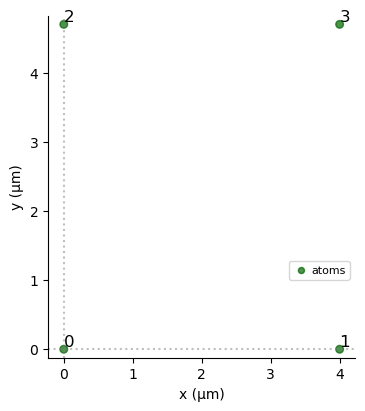

In [7]:
# ========== STEP 2: Atom Positions & Register ==========
positions = {
    0: (0, 0),
    1: (4.0, 0.0),   # Distance from 0: 4.0µm → V₀₁ ≈ 55 rad/µs
    2: (0.0, 4.7),    # Distance from 0: 4.7µm → V₀₂ ≈ 50 rad/µs
    3: (4.0, 4.7)     # Distance from 1: 4.7µm → V₁₃ ≈ 50 rad/µs
}

reg = Register(positions)
reg.draw()

In [8]:
# ========== STEP 3: Pulse Sequence with Per-Atom Detuning ==========
seq = Sequence(reg, custom_device)

# Global Rydberg driving (Ω(t))
seq.declare_channel("global", "rydberg_global", initial_target="all")
amp_wf = BlackmanWaveform(4000, 15)  # Ω: 15 → 0 rad/µs
global_pulse = Pulse(amp_wf, RampWaveform(4000, 0, 0), 0)
seq.add(global_pulse, "global")

# Individual detuning patterns (δᵢ(t))
seq.declare_channel("local", "local_detuning", initial_target=0)

# Detuning values from QUBO (scaled to device limits)
detuning = [-100, 13.75, 27.5, 55]  # rad/µs

# For local channel (amplitude must always be ZERO)

for q in range(4):
    seq.target(q, "local")
    seq.add(
        Pulse(
            amplitude=ConstantWaveform(4000, 0),  # Amplitude fixed at 0
            detuning=RampWaveform(4000, 0, detuning[q]),
            phase=0
        ),
        "local"
    )

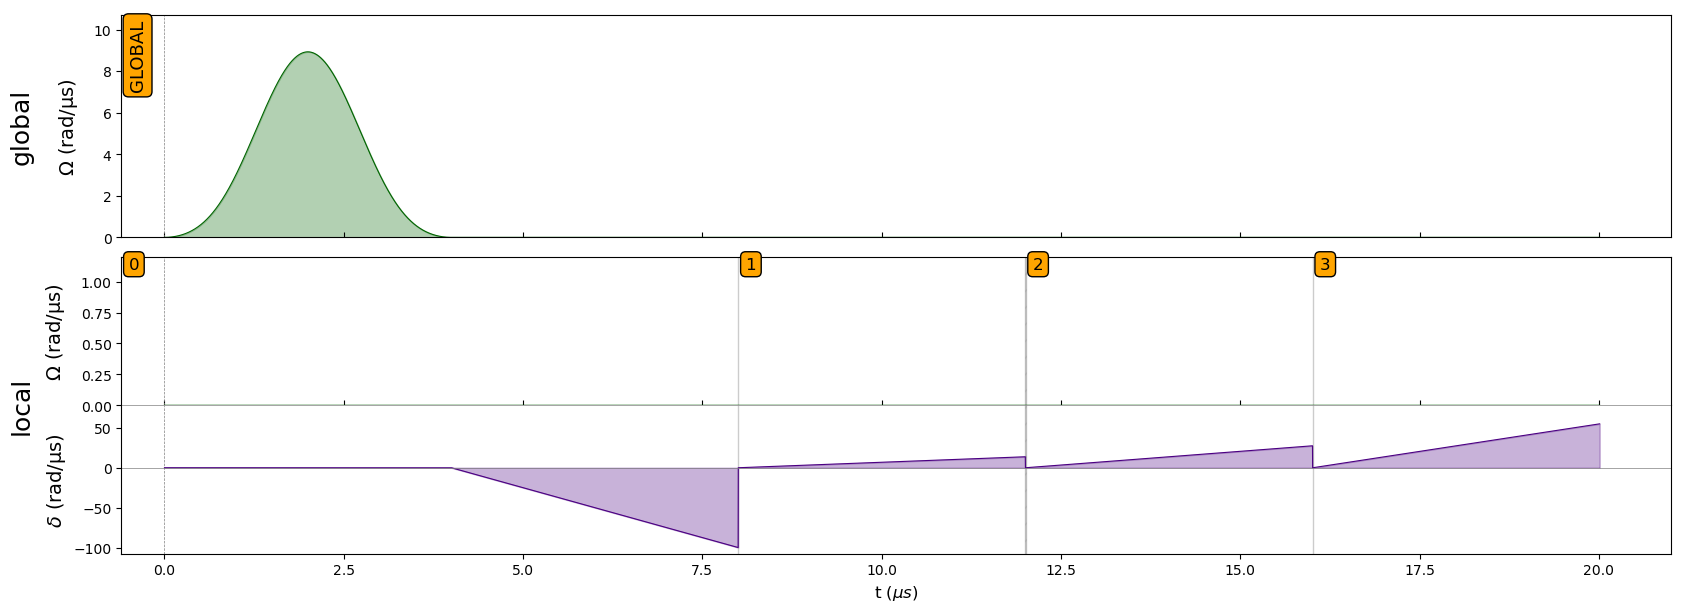

In [9]:
seq.draw()

In [10]:
# ========== STEP 4: Simulation & Analysis ==========
simul = QutipEmulator.from_sequence(seq)
results = simul.run()

# Get final state probabilities (after 1000 shots)
counts = results.sample_final_state(1000)
print("Measurement results:", counts)

Measurement results: Counter({'1000': 242, '0100': 233, '0001': 229, '0010': 207, '0000': 89})


In [11]:
# Convert all bitstrings to their corresponding assignment dictionaries
assignments = {bit: bitstring_to_assignment(bit) for bit in counts}

# Example: Print out each bitstring's assignment and its count
for bit, count in counts.items():
    print(f"Bitstring: {bit}, Count: {count}, Assignment: {assignments[bit]}")


Bitstring: 0000, Count: 89, Assignment: {0: 0, 1: 0, 2: 0, 3: 0}
Bitstring: 0001, Count: 229, Assignment: {0: 0, 1: 0, 2: 0, 3: 1}
Bitstring: 0010, Count: 207, Assignment: {0: 0, 1: 0, 2: 1, 3: 0}
Bitstring: 0100, Count: 233, Assignment: {0: 0, 1: 1, 2: 0, 3: 0}
Bitstring: 1000, Count: 242, Assignment: {0: 1, 1: 0, 2: 0, 3: 0}


In [13]:
print(evaluate_solution({0: 1, 1: 0, 2: 0, 3: 0}, [6, 6], [324.07, 285.41], ['Panamax_A', 'NeoPanamax']))
print(evaluate_solution({0: 0, 1: 1, 2: 0, 3: 0}, [6, 6], [324.07, 285.41], ['Panamax_A', 'NeoPanamax']))
print(evaluate_solution({0: 0, 1: 0, 2: 0, 3: 1}, [6, 6], [324.07, 285.41], ['Panamax_A', 'NeoPanamax']))

(365, 30, 65, 400, 0, 0, ['Ship 2 assigned 0 times (Expected 1).', 'Time slot 0 exceeds lock length by 30.069999999999993 meters'])
(180, 45, 65, 200, 0, 0, ['Ship 2 assigned 0 times (Expected 1).'])
(180, 45, 65, 200, 0, 0, ['Ship 1 assigned 0 times (Expected 1).'])
